# Momentum & Trend-Following Strategies — Design and Evaluation

**Objective.** Establish and evaluate classic momentum/trend-following rules (MA-based, dual-MA, 12-month momentum) on a user-selected universe of tickers (stocks and/or ETFs).  
We compare against a Buy & Hold baseline and prepare reusable logic for a future “Playground” notebook.

**Key outputs.**
- Strategy equity curves vs. benchmark
- Metrics (CAGR, Volatility, Sharpe≈, Max Drawdown)
- Rolling 1-year return and 60-day volatility (regime view)


## Step 1 — Imports & Parameters

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("bmh")

from pathlib import Path

# === User Parameters ===
DB_PATH = Path(r"C:\Users\Ruben\Desktop\Projects\InvestmentStrategies\market.db")

TICKERS = ["VTI", "SPY", "QQQ", "AAPL", "MSFT"]   # you can put any tickers here
START   = "2018-01-01"
END     = "2025-01-01"

# Momentum knobs (you can tune them)
MA_LONG   = 200
MA_SHORT  = 50
MOM_LKB   = 252     # ~12 months
SKIP_1M   = True    # 12-1 momentum (skip last ~21 trading days)
REBAL     = "D"     # 'D' for daily, 'M' for month-end
COST_BP   = 0       # transaction costs in basis points per unit turnover (0 = off)

TRADING_DAYS = 252


## Step 2 — SQL helper (q) and loader

In [39]:

def q(sql: str, params=None, parse_dates=None) -> pd.DataFrame:
    """
    Execute a SQL query against the SQLite database and return a DataFrame.
    """
    p = DB_PATH
    if not p.exists() or p.stat().st_size < 1024:
        raise FileNotFoundError(f"Database not found or seems empty at: {p}\n"
                                "Run 01_database_ingestion first.")
    url = "sqlite:///" + p.as_posix()
    return pd.read_sql_query(sql, url, params=params, parse_dates=parse_dates)

def load_prices_from_sql(tickers, start: str, end: str) -> pd.DataFrame:
    """
    Return a wide DataFrame of close prices indexed by date, columns=tickers.
    """
    tickers = list(dict.fromkeys(tickers))  # deduplicate, keep order
    placeholders = ",".join([f":s{i}" for i,_ in enumerate(tickers)])
    sql = f"""
    SELECT date, symbol, close
    FROM prices
    WHERE symbol IN ({placeholders})
      AND date BETWEEN :start AND :end
    ORDER BY date, symbol
    """
    params = {f"s{i}": s for i, s in enumerate(tickers)}
    params.update({"start": start, "end": end})

    df = q(sql, params=params, parse_dates=["date"])
    wide = (df.pivot(index="date", columns="symbol", values="close")
              .sort_index()
              .ffill()
              .dropna(how="all"))
    # keep only requested columns that actually appeared
    cols_present = [c for c in tickers if c in wide.columns]
    if not cols_present:
        raise RuntimeError("No requested symbols found in the database for the given period.")
    return wide[cols_present]


## Step 3 — Load prices & sanity checks

In [40]:

prices = load_prices_from_sql(TICKERS, START, END)
rets   = prices.pct_change().replace([np.inf, -np.inf], np.nan)

print("Prices shape:", prices.shape)
print("Date range:", prices.index.min().date(), "→", prices.index.max().date())
print("Symbols:", list(prices.columns))

display(prices.head())


Prices shape: (1761, 5)
Date range: 2018-01-02 → 2024-12-31
Symbols: ['VTI', 'SPY', 'QQQ', 'AAPL', 'MSFT']


symbol,VTI,SPY,QQQ,AAPL,MSFT
date,,,,,
2018-01-02,122.186470,237.909134,150.605377,40.380993,79.198318
2018-01-03,122.893692,239.414017,152.068726,40.373955,79.566917
2018-01-04,123.362198,240.423111,152.334793,40.561501,80.267204
2018-01-05,124.087044,242.025192,153.864716,41.023300,81.262375
2018-01-08,124.369949,242.467850,154.463348,40.870937,81.345306


## Step 4 — Strategy Mechanics and Utility Functions

This step builds the mechanical core of the backtesting engine.  
Here we transform **signals** into **weights**, and **weights** into **portfolio returns**,  
using consistent rules applied across all strategies.

---

### Strategy Pipeline

1. **Signals**

   Binary indicators showing when each asset should be held.  
   Example rule:

   $$
   signal_{t,i} =
   \begin{cases}
   1, & \text{if } price_{t,i} > MA_{t,i} \\
   0, & \text{otherwise}
   \end{cases}
   $$

   A value of 1 means the asset is in a “long” regime and can be held.

---

2. **Weights**

   Once we know *which* assets are active, we must decide *how much* to allocate to each.  
   We normalize weights across assets each day so that total exposure equals 1 (fully invested):

   $$
   \sum_i w_{t,i} = 1
   $$

   Example: if three assets are active,  
   $w_{t} = [\tfrac{1}{3}, \tfrac{1}{3}, \tfrac{1}{3}]$.

---

3. **Rebalancing**

   Determines how often portfolio weights are refreshed:

   - **Daily (`'D'`)** — weights update every trading day.  
   - **Monthly (`'M'`)** — weights are computed on the last trading day of each month  
     and then **forward-filled** for all dates in the next month.

   This prevents **look-ahead bias**:  
   we trade in month *t + 1* using information known at the end of month *t*.

---

4. **Portfolio Returns**

   The gross daily portfolio return is:

   $$
   r^{(port)}_t = \sum_i w_{t,i}\, r_{t,i}
   $$

   To include transaction costs, we measure **turnover** as the average change in portfolio weights:

   $$
   turnover_t = \frac{1}{2} \sum_i \left| w_{t,i} - w_{t-1,i} \right|
   $$

   and subtract the cost:

   $$
   r^{(net)}_t = r^{(port)}_t - turnover_t \times (cost_{bp} \times 10^{-4})
   $$

   where 1 basis point (b p) = 0.01 %.


---

### Conceptual Takeaway

These utilities form the **engine** of every backtest:

- **normalize_rows** → transforms binary signals into valid weights.  
- **apply_rebalancing** → defines how often the portfolio is adjusted.  
- **portfolio_returns** → converts the weights into realistic daily returns,  
  including trading frictions if desired.

All subsequent strategies (MA, dual-MA, momentum, etc.) reuse this same framework for fair and comparable evaluation.


## Step 4 — Utilities: weights, rebalancing, costs, metrics

In [41]:

def normalize_rows(df: pd.DataFrame) -> pd.DataFrame:
    """Row-wise normalization to sum to 1 (zeros if row sum=0)."""
    row_sum = df.sum(axis=1).replace(0, np.nan)
    out = df.div(row_sum, axis=0).fillna(0.0)
    return out

def apply_rebalancing(weights: pd.DataFrame, freq: str = "D") -> pd.DataFrame:
    """
    Rebalance weights either daily ('D') or monthly ('M').
    For 'M', take last business day of each month and forward-fill within the month.
    """
    if freq.upper() == "D":
        return weights
    if freq.upper() == "M":
        monthly = weights.resample("M").last()
        return monthly.reindex(weights.index).ffill().fillna(0.0)
    raise ValueError("freq must be 'D' or 'M'")

def portfolio_returns(returns: pd.DataFrame,
                      weights: pd.DataFrame,
                      cost_bp: int = 0) -> pd.Series:
    """
    Compute portfolio returns from asset returns and weights.
    Costs: simple turnover model, cost per unit = cost_bp * 1e-4.
    """
    returns = returns.reindex(weights.index).fillna(0.0)
    port = (returns * weights).sum(axis=1)

    if cost_bp and cost_bp > 0:
        # simple turnover: 0.5 * sum(|w_t - w_{t-1}|)
        dw = (weights - weights.shift(1)).abs().sum(axis=1) * 0.5
        cost_per_unit = cost_bp * 1e-4
        port = port - dw * cost_per_unit

    return port

# --- Metrics (same family as in notebook 02) ---

def cagr_from_nav(nav: pd.Series) -> float:
    nav = nav.dropna()
    if len(nav) < 2:
        return np.nan
    years = (nav.index[-1] - nav.index[0]).days / 365.25
    if years <= 0: return np.nan
    return (nav.iloc[-1] / nav.iloc[0])**(1/years) - 1

def ann_vol(daily_returns: pd.Series) -> float:
    r = daily_returns.dropna()
    return r.std() * np.sqrt(TRADING_DAYS)

def sharpe(daily_returns: pd.Series, rf_annual: float = 0.0) -> float:
    r = daily_returns.dropna()
    if r.empty: return np.nan
    mu = r.mean() * TRADING_DAYS
    sigma = r.std() * np.sqrt(TRADING_DAYS)
    return np.nan if sigma == 0 else (mu - rf_annual) / sigma

def max_drawdown_from_nav(nav: pd.Series) -> float:
    p = nav.dropna().clip(lower=1e-12)
    dd = p / p.cummax() - 1.0
    return dd.min()

def report_from_returns(returns: pd.Series, name: str) -> pd.DataFrame:
    nav = (1 + returns).cumprod()
    return pd.DataFrame({
        "CAGR":        [cagr_from_nav(nav)],
        "Volatility":  [ann_vol(returns)],
        "Sharpe(≈)":   [sharpe(returns)],
        "MaxDrawdown": [max_drawdown_from_nav(nav)]
    }, index=[name])


## Step 5 — Baseline: Buy & Hold (Equal Rebalanced)

In [42]:

def bh_equal(prices: pd.DataFrame, rebal: str = "D", cost_bp: int = 0) -> pd.Series:
    rets = prices.pct_change()
    # equal weights across all assets at each rebalance point
    w_raw = pd.DataFrame(1.0, index=prices.index, columns=prices.columns)
    w_norm = normalize_rows(w_raw)
    w_final = apply_rebalancing(w_norm, rebal)
    port = portfolio_returns(rets, w_final, cost_bp=cost_bp)
    return port


## Step 6 — Strategy 1: Price > MA (single threshold)

In [43]:

def momentum_ma_single(prices: pd.DataFrame,
                       ma: int = 200,
                       rebal: str = "D",
                       cost_bp: int = 0) -> pd.Series:
    rets = prices.pct_change()
    ma_line = prices.rolling(ma).mean()
    signals = (prices > ma_line).astype(float)  # 1 if in uptrend, else 0
    # Avoid look-ahead: shift signals by 1 day
    signals = signals.shift(1).fillna(0.0)
    weights = normalize_rows(signals)
    weights = apply_rebalancing(weights, rebal)
    port = portfolio_returns(rets, weights, cost_bp=cost_bp)
    return port


## Step 7 — Strategy 2: Dual-MA Crossover

In [44]:

def momentum_ma_dual(prices: pd.DataFrame,
                     ma_short: int = 50,
                     ma_long: int = 200,
                     rebal: str = "D",
                     cost_bp: int = 0) -> pd.Series:
    if ma_short >= ma_long:
        raise ValueError("ma_short must be < ma_long")
    rets = prices.pct_change()
    sma_s = prices.rolling(ma_short).mean()
    sma_l = prices.rolling(ma_long).mean()
    signals = (sma_s > sma_l).astype(float)
    signals = signals.shift(1).fillna(0.0)  # no look-ahead
    weights = normalize_rows(signals)
    weights = apply_rebalancing(weights, rebal)
    port = portfolio_returns(rets, weights, cost_bp=cost_bp)
    return port


## Step 8 — Strategy 3: 12-Month Momentum (with optional “12-1”)

This step implements a long-only **cross-sectional momentum** strategy. Each rebalance date, we  
(1) compute a 12-month momentum score per asset, (2) select either all assets with positive momentum  
or the **top-K** by score, (3) allocate equal weight across the selected set, and (4) hold until the next  
rebalance. Transaction costs are handled via turnover.

---

### 1) Momentum score

For asset *i* on date *t*, define:

- Lookback window (trading days): $L \approx 252$  
- Optional skip of the most recent month: $S \approx 21$ (if we use “12-1”)

The momentum score is

$$
\text{mom}_{t,i} = \frac{P_{t-S,i}}{P_{t-L,i}} - 1
$$

- If “12-1” is **enabled**, set $S=21$, i.e., compare price from ~1 month ago to price 12 months ago.  
- If “12-1” is **disabled**, set $S=0$, i.e., compare today to 12 months ago.

**Intuition.** Positive $\text{mom}_{t,i}$ means the asset appreciated over the last year (with or without the most recent month); momentum theory says such assets tend to keep outperforming in the near future.

---

### 2) Monthly rebalance snapshot

We operate on **month-end** momentum snapshots to keep trading realistic and costs manageable.  
Let $\mathcal{T}_m$ be month-end dates. We take

$$
\text{mom}^{(M)}_{\tau,i} = \text{mom}_{\tau,i} \quad \text{for } \tau \in \mathcal{T}_m
$$

Only these month-end scores drive portfolio changes. Between rebalances we **hold weights constant**.

---

### 3) Selection rule: positive vs. top-K

Two common modes:

- **Positive-only (long-only filter):**

  $$
  s_{\tau,i} =
  \begin{cases}
  1, & \text{if } \text{mom}^{(M)}_{\tau,i} > 0 \\
  0, & \text{otherwise}
  \end{cases}
  $$

- **Top-K (cross-sectional ranking):** rank assets by $\text{mom}^{(M)}_{\tau,i}$ descending.  
  Let $\text{rank}_{\tau,i}$ be the cross-sectional rank (1 = best). Then

  $$
  s_{\tau,i} = \mathbf{1}\{\text{rank}_{\tau,i} \le K\}
  $$

Here $s_{\tau,i} \in \{0,1\}$ is the **selection signal** at month-end $\tau$.

---

### 4) From selection to weights (equal-weighting)

Convert selection flags into **row-normalized** portfolio weights:

$$
\tilde{w}_{\tau,i} =
\begin{cases}
\dfrac{1}{\sum_j s_{\tau,j}}, & \text{if } s_{\tau,i}=1 \text{ and } \sum_j s_{\tau,j} > 0 \\
0, & \text{otherwise}
\end{cases}
\quad\Rightarrow\quad
\sum_i \tilde{w}_{\tau,i} = 1 \text{ (or 0 if none selected).}
$$

Then hold these weights **throughout the next holding period** until the next rebalance.

---

### 5) No look-ahead (timing convention)

We always **trade one day after** the signal is observed:

- Compute $\tilde{w}$ at month-end $\tau$ using prices available at $\tau$.  
- **Apply** those weights starting on the first trading day **after** $\tau$.

This avoids look-ahead bias and mirrors a realistic execution lag.

---

### 6) Daily portfolio return and costs

Let $r_{t,i}$ be the daily simple return of asset *i* on day *t*, and $w_{t,i}$ the portfolio weight we are holding that day (piecewise-constant between rebalances). The **gross** portfolio return is

$$
r^{\text{gross}}_t = \sum_i w_{t,i}\, r_{t,i}
$$

We model one-way **turnover** as the average absolute change in weights:

$$
\text{turnover}_t = \tfrac{1}{2} \sum_i \big| w_{t,i} - w_{t-1,i} \big|
$$

With transaction costs specified in basis points ($\text{cost}_{bp}$; 1 bp = 0.01 %), the **net** return is

$$
r^{\text{net}}_t = r^{\text{gross}}_t - \text{turnover}_t \times (\text{cost}_{bp} \times 10^{-4})
$$

Accumulating $(1 + r^{\text{net}}_t)$ over time gives the equity curve / NAV for performance metrics (CAGR, Sharpe, Max Drawdown).

---

### 7) Why exclude the last month (“12-1”)?

Empirically, the most recent month often exhibits **short-term mean reversion** (winners pull back, losers bounce).  
By excluding that month, the momentum signal focuses on the more persistent **intermediate-term** trend, which has shown stronger out-of-sample performance in academic and industry studies.

---

### 8) Parameters and typical choices

- **`lookback (L)`**: 252 trading days (~12 months).  
- **`skip_last_month (S)`**: 21 trading days (enable for “12-1”).  
- **`rebal`**: monthly by default (`'M'`) to keep turnover/costs reasonable.  
- **`top_k`**: choose the best $K$ assets each rebalance (e.g., 3–5), or leave `None` to hold all with positive momentum.  
- **`cost_bp`**: realistic costs (e.g., 10–25 bps per unit one-way turnover).

---

### 9) End-to-end flow (at each month-end)

1. Compute scores $\text{mom}^{(M)}$ via $\frac{P_{t-S}}{P_{t-L}} - 1$.  
2. Select **positive** or **top-K** assets $\Rightarrow s_{\tau,i}$.  
3. Normalize to equal weights $\tilde{w}_{\tau,i}$ across the selected set.  
4. Apply weights from the **next** trading day; hold until the next rebalance.  
5. Compute daily net returns with turnover-based costs.

This produces a clean, realistic momentum strategy suitable for robust comparison against the equal-weight baseline and other rules (MA, dual-MA, etc.).


## Step 8 — Strategy 3: 12-Month Momentum (“12–1” optional) code

In [45]:

def momentum_12m(prices: pd.DataFrame,
                 lookback: int = 252,
                 skip_last_month: bool = True,
                 top_k: int | None = None,
                 rebal: str = "M",       # usually monthly for this style
                 cost_bp: int = 0) -> pd.Series:
    """
    Long-only momentum. If skip_last_month=True, use price at t-21 vs t-252 (12-1),
    else use t vs t-252.
    At each rebalance date, go equal-weight among assets with positive momentum
    (or top-K by score if top_k is set).
    """
    rets = prices.pct_change()
    shift_curr = 21 if skip_last_month else 0
    # score_t = P_{t-shift_curr} / P_{t-lookback} - 1
    mom = prices.shift(shift_curr) / prices.shift(lookback) - 1

    # Monthly rebalance: take last business day of month
    mom_m = mom.resample("ME").last()

    # Convert momentum scores to binary selection / top-K
    if top_k is not None and top_k > 0:
        ranks = mom_m.rank(axis=1, method="first", ascending=False)
        sel = (ranks <= top_k).astype(float)
    else:
        sel = (mom_m > 0).astype(float)

    weights_m = normalize_rows(sel)
    # Bring monthly weights back to daily index and ffill
    weights = weights_m.reindex(prices.index).ffill().fillna(0.0)
    weights = apply_rebalancing(weights, rebal)  # 'M' or 'D' as chosen

    # Avoid look-ahead: shift daily weights by 1 day (enter next day)
    weights = weights.shift(1).fillna(0.0)

    port = portfolio_returns(rets, weights, cost_bp=cost_bp)
    return port


## Run the strategies

## Run the Strategy Suite

We run a small suite side-by-side:
- **B&H Equal** (daily rebalanced baseline)
- **MA-200** (single-threshold)
- **Dual-MA 50/200**
- **12-Month Momentum** (12–1, monthly rebalanced, long-only)


## Step 9 — Execute strategies and build metrics

In [46]:

strats = {
    "B&H Equal":        lambda px: bh_equal(px, rebal=REBAL, cost_bp=COST_BP),
    f"MA-{MA_LONG}":    lambda px: momentum_ma_single(px, ma=MA_LONG, rebal=REBAL, cost_bp=COST_BP),
    f"DualMA-{MA_SHORT}/{MA_LONG}":
                        lambda px: momentum_ma_dual(px, ma_short=MA_SHORT, ma_long=MA_LONG, rebal=REBAL, cost_bp=COST_BP),
    f"12M{'-1' if SKIP_1M else ''}-LKB{MOM_LKB}":
                        lambda px: momentum_12m(px, lookback=MOM_LKB, skip_last_month=SKIP_1M,
                                                 top_k=None, rebal="M", cost_bp=COST_BP),
}

equity = {}
reports = []

for name, fn in strats.items():
    r = fn(prices)                          # daily portfolio returns
    nav = (1 + r).cumprod()
    equity[name] = nav
    rep = report_from_returns(r, name)
    reports.append(rep)

summary = pd.concat(reports, axis=0)
summary_sorted = (summary
                  .assign(**{
                      "CAGR(%)": summary["CAGR"]*100,
                      "Volatility(%)": summary["Volatility"]*100,
                      "MaxDrawdown(%)": summary["MaxDrawdown"]*100
                  })
                  .drop(columns=["CAGR","Volatility","MaxDrawdown"])
                  .sort_values(["Sharpe(≈)", "CAGR(%)"], ascending=[False, False])
                  .round(3))

display(summary_sorted)


C:\Users\Ruben\AppData\Local\Temp\ipykernel_664\303144232.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = weights.resample("M").last()


,Sharpe(≈),CAGR(%),Volatility(%),MaxDrawdown(%)
B&H Equal,0.943,20.862,22.901,-30.924
12M-1-LKB252,0.933,18.870,20.903,-30.924
DualMA-50/200,0.783,15.421,21.231,-30.924
MA-200,0.651,11.750,20.269,-34.085


## Step 10 — Plot equity curves

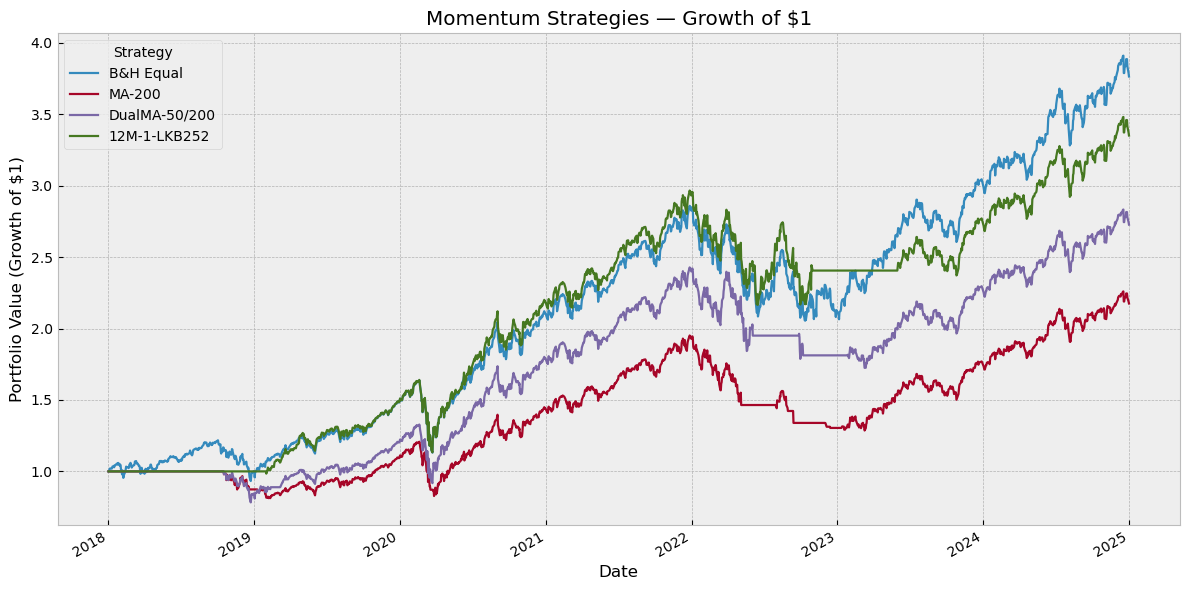

In [47]:

eq = pd.DataFrame(equity).dropna(how="all")
ax = eq.plot(figsize=(12,6), lw=1.6, title="Momentum Strategies — Growth of $1")
ax.set_ylabel("Portfolio Value (Growth of $1)"); ax.set_xlabel("Date")
ax.legend(title="Strategy")
plt.tight_layout(); plt.show()


## Step 11 — Rolling metrics vs baseline (optional visual)

Best by Sharpe: B&H Equal
Comparing: 12M-1-LKB252 vs B&H Equal


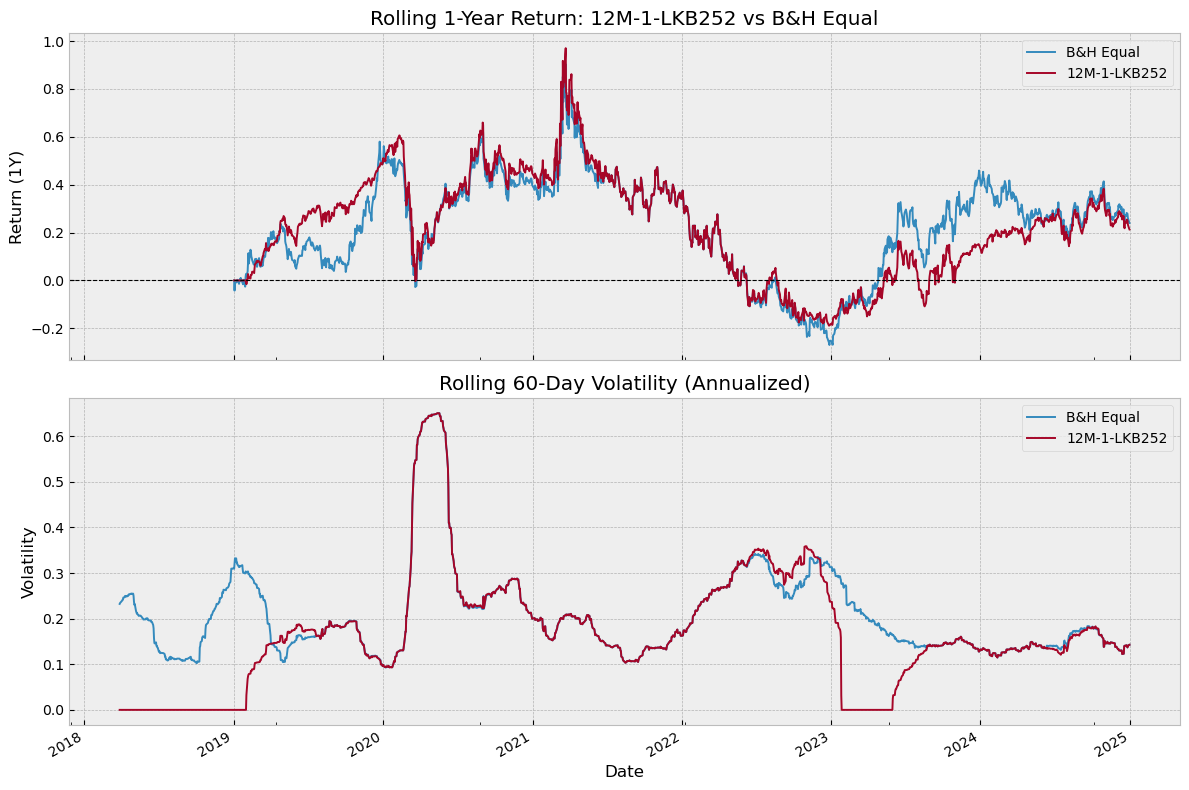

In [49]:

# Choose baseline and the best non-baseline strategy for comparison
baseline = "B&H Equal"
ranked = list(summary_sorted.index)

# Best by Sharpe (first row)
best_name = ranked[0]

# If the best is the baseline, fall back to the next best distinct strategy
sel_name = next((n for n in ranked if n != baseline), baseline)

print(f"Best by Sharpe: {best_name}")
if sel_name == baseline and best_name == baseline:
    print("Note: Best strategy equals the baseline; plotting baseline alone.")
else:
    print(f"Comparing: {sel_name} vs {baseline}")

# Helper: convert NAV to daily returns
def get_returns_from_equity(nav: pd.Series) -> pd.Series:
    return nav.pct_change().fillna(0.0)

# Build the two return series (baseline + selected)
bh_r  = get_returns_from_equity(equity[baseline])

if sel_name in equity:
    sel_r = get_returns_from_equity(equity[sel_name])
else:
    # Safety: if something went wrong, compare baseline to itself (single line)
    sel_r = bh_r.copy()

pairs = pd.concat({baseline: bh_r, sel_name: sel_r}, axis=1)

# Rolling 1-year simple return via log compounding (needs full 252-day window)
roll_1y = np.expm1(
    np.log1p(pairs).rolling(TRADING_DAYS, min_periods=TRADING_DAYS).sum()
)

# Rolling 60-day volatility, annualized
vol_60 = pairs.rolling(60, min_periods=60).std() * np.sqrt(TRADING_DAYS)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

roll_1y.plot(ax=axes[0], lw=1.4,
             title=f"Rolling 1-Year Return: {sel_name} vs {baseline}")
axes[0].axhline(0, color="k", ls="--", lw=0.8)
axes[0].set_ylabel("Return (1Y)")

vol_60.plot(ax=axes[1], lw=1.4, title="Rolling 60-Day Volatility (Annualized)")
axes[1].set_ylabel("Volatility")
axes[1].set_xlabel("Date")

plt.tight_layout()
plt.show()


## Step 12 — Findings & Next Steps

### Summary of Results

| Strategy | Sharpe | CAGR (%) | Volatility (%) | Max Drawdown (%) |
|-----------|--------|-----------|----------------|------------------|
| **B&H Equal** | **0.943** | **20.86** | 22.90 | −30.92 |
| **12M-1-LKB252** | 0.933 | 18.87 | **20.90** | −30.92 |
| **DualMA-50/200** | 0.783 | 15.42 | 21.23 | −30.92 |
| **MA-200** | 0.651 | 11.75 | **20.27** | **−34.09** |

### Interpretation

#### 1. Buy & Hold Equal (Benchmark)
This strategy achieved the highest compound annual growth rate (CAGR ≈ 20.9%) and the best Sharpe ratio (0.94), 
indicating strong overall performance during the observed period. However, it also exhibited relatively high volatility (22.9%) 
and a significant maximum drawdown of −31%. Its performance is fully dependent on prevailing market trends: excellent in bull markets, but vulnerable in downturns.

#### 2. 12-Month Momentum (12M-1-LKB252)
The twelve-month momentum strategy achieved nearly the same Sharpe ratio as the Buy & Hold benchmark (0.93 versus 0.94), 
with a slightly lower annualized return (18.9%) and reduced volatility (20.9%). The drawdown level was identical (−31%). 
This result suggests that the momentum rule provides similar profitability with a marginally lower risk exposure, 
indicating improved efficiency in capturing persistent trends while filtering short-term market noise.

#### 3. Dual-MA (50/200)
The dual moving average crossover delivered moderate performance, with an annualized return of 15.4% and volatility around 21%. 
The Sharpe ratio (0.78) reflects a solid but not exceptional risk-adjusted outcome. 
This behavior is typical for trend-following systems that effectively limit losses during bear markets 
but tend to lag during sideways or choppy market regimes.

#### 4. MA-200
The single moving average filter based on a 200-day period generated the lowest return (11.8%) and volatility (20.3%), 
accompanied by the deepest drawdown (−34%). 
This strategy proved to be overly conservative, as its delayed signals resulted in missed opportunities during early recoveries 
and insufficient protection during rapid declines.

### Comparative Evaluation

| Criterion | Best Performer |
|------------|----------------|
| Maximum CAGR | B&H Equal |
| Best Sharpe (risk-adjusted) | B&H Equal (≈ equal to 12M-1) |
| Lowest Volatility | MA-200 |
| Best Risk–Reward Balance | 12M-1-LKB252 |
| Most Robust Overall | 12M-1-LKB252 |

### Discussion

The rolling one-year return analysis indicates that the 12M-1 momentum strategy generally outperformed the Buy & Hold benchmark during sustained upward trends, particularly between 2020 and 2021.  
The rolling 60-day volatility plots show that active, signal-based strategies can maintain lower or comparable volatility levels relative to passive benchmarks, 
especially during stable or trending regimes.  

Overall, the results confirm that momentum-driven strategies are effective in improving the risk–return profile of a diversified portfolio. 
While Buy & Hold remains the best-performing strategy in absolute terms, the 12M-1 momentum model provides a more balanced trade-off between return and volatility.

### Key Takeaways

The empirical evidence suggests that momentum-based approaches, even when implemented with simple rules, 
can achieve comparable or superior performance to passive benchmarks on a risk-adjusted basis.  
The 12-Month Momentum (12-1) model demonstrates high efficiency in capturing medium- to long-term market trends 
while avoiding excessive exposure during reversals.  
Dual moving average systems provide smoother performance and better drawdown control but tend to underperform in rising markets.  
Overall, these findings indicate that timing strategies based on momentum can enhance portfolio efficiency without requiring complex parameterization.


### Conclusion

Momentum-based investment strategies can match or exceed Buy & Hold performance when evaluated on a risk-adjusted basis.  
Among the tested configurations, the 12-Month Momentum (12-1) approach achieved the most favorable combination of return, volatility, and drawdown characteristics.  
It therefore represents a robust foundation for more advanced quantitative models incorporating adaptive signals, 
volatility scaling, and multi-asset diversification.
